# Problem Demonstration

In [5]:
import random
import torch
import numpy as np
from tqdm.auto import trange
from tqdm import tqdm

from scipy.optimize import minimize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.test_functions import Hartmann

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from matplotlib import pyplot as plt
plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)

## Define Some Helper Function

In [6]:
def set_seeds(seed=42):
    """set all library random seeds"""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sample(num_points, dims, seed=42):
    """generate random points in the domain"""
    set_seeds(seed)
    return torch.rand(num_points, dims)

def restarts_optimizer(gp, bounds):
    X_vals = []
    acqf = []
    for i in [1,2,3,4,5]:
        set_seeds(i)
        X_new, acq_value = optimize_acqf(
            acq_function= UpperConfidenceBound(gp, beta=2),
            bounds=bounds,
            q=1, # how many new points to generate
            num_restarts = 20, # how many times to restart the optimizer
            raw_samples = 200, # how many initial points to sample acqf space from
        )
        X_vals.append(X_new)
        acqf.append(acq_value)
    
    return X_vals[np.argmax(acqf)]

def nearest_power_of_two(n):
    power = round(np.log2(n))
    return 2 ** power

seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

In [7]:
seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)
n_init = 5
n_campaigns = 1
budget = 30-n_init

data = np.zeros((n_campaigns, n_init+budget))

# generate starting data values
HART = Hartmann(dim=6, bounds=[(0,1)]*6 ,negate=True)
X_ = random_sample(n_init, 6)
y_ = torch.tensor([HART(x) for x in X_])[:,None]

for i in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(seeds[i]) # set the random seed for the campaign
    X = X_.clone()
    y = y_.clone()


    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = SingleTaskGP(
            train_X = X,
            train_Y = y,
            input_transform=Normalize(d=X.shape[-1]), # normalize X values
            outcome_transform=Standardize(m=y.shape[-1]) # standardize y values
        )

        # fit the model by maximizing the log marginal likelihood
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_model(mll)

        bounds = torch.tensor([[0.0]*X.shape[-1], [1.0]*X.shape[-1]])

        X_new = restarts_optimizer(gp, bounds)
        set_seeds(seeds[i])

        X = torch.cat([X, X_new])
        y = torch.cat([y, HART(X=X_new)[:,None]])

        pbar0.set_description(f"Processing Trial {j+1} of Campaign {i+1}")
        pbar1.set_description(f"Campaign {i+1} | Best Value {round(torch.max(y).item(),3)}")


    data[i,:] = y.flatten()

Campaign 1 | Best Value 3.32: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]t/s]
Processing Trial 25 of Campaign 1: 100%|██████████| 1/1 [00:16<00:00, 16.66s/it]


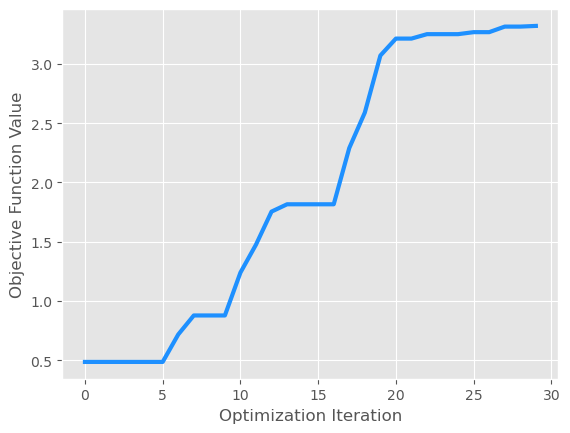

In [8]:
best_to_trial = np.maximum.accumulate(data, axis=1)
best_to_trial_mean = np.mean(best_to_trial, axis=0)
plt.plot(best_to_trial.T, color='black', alpha=0.25, label='trials')
plt.plot(best_to_trial_mean, lw=3, color='dodgerblue', label='mean')
plt.xlabel('Optimization Iteration')
plt.ylabel('Objective Function Value')
plt.show()